In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.metrics import error_rate
import torch
import fastai
from fastai.tabular.all import *
from fastai.text.all import *
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from keras import backend as K
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, SeparableConv2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from pathlib import Path
import cv2
import os
import pandas as pd

In [2]:
code_folder='/media/user/F/BME_400_Group_02/codes/Transfer_learing/resnet50/'
model_folder='/media/user/F/BME_400_Group_02/codes/Transfer_learing/resnet50/model/'
data_folder='/media/user/F/BME_400_Group_02/chest_xray_test_val_train/'
#data_folder='/media/user/F/BME_400_Group_02/chest_xray/'

In [3]:
#x=data_folder
#path = Path(x)
#path.ls()

In [4]:
labels = ['NORMAL','PNEUMONIA']
img_size = 180

Train set:
PNEUMONIA=2912
NORMAL=1015
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=971
NORMAL=334


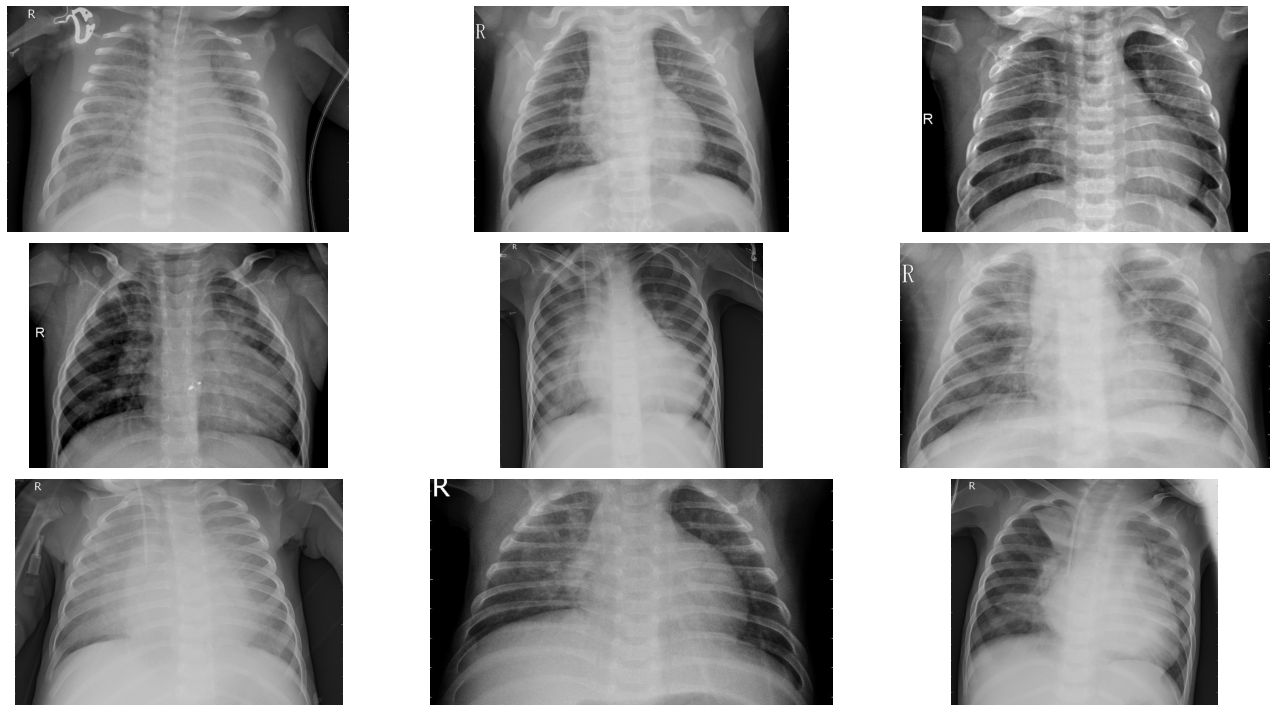

In [5]:
train_dir = data_folder+"train"
test_dir = data_folder+"test"
val_dir = data_folder+"val"

print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir(os.path.join(train_dir, 'PNEUMONIA'))
pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

In [6]:
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    #height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
    #horizontal_flip=True
)
test_generator = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True
    #horizontal_flip=True
)

In [7]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(img_size, img_size))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(img_size, img_size))

test = test_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(img_size, img_size))


Found 3927 images belonging to 2 classes.
Found 1305 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 180 pixels width and 180 pixels height, one single color channel.
The maximum pixel value is 3.1090 and the minimum is -2.8243
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


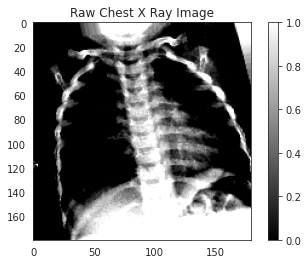

In [8]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

/home/user/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

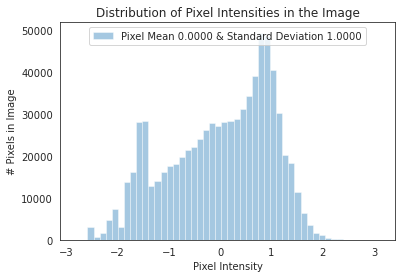

In [9]:
sns.distplot(generated_image.ravel(),
            label=f"Pixel Mean {np.mean(generated_image):.4f} & Standard Deviation {np.std(generated_image):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [10]:
weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

#weight_for_0 = (cnt_normal)/(cnt_normal+cnt_pneumonia)
#weight_for_1 = (cnt_pneumonia)/(cnt_normal+cnt_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

#class_weights=class_weight.compute_class_weight(class_weight='balanced',
#                                             classes=sorted(np.unique(y_train)),
#                                             y=y_train)
#class_weights=dict(enumerate(class_weights))

weight_for_0, weight_for_1


(0.7415329768270945, 0.25846702317290554)

In [11]:
from keras.applications import ResNet50

resnet_base_model = ResNet50(input_shape=(img_size,img_size,3), include_top=False, weights='imagenet',classes=2)

2022-12-02 01:16:41.893581: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 01:16:41.897753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 01:16:41.898164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 01:16:41.898933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [12]:
resnet_base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']      

In [13]:
resnet_model = tf.keras.Sequential([
    resnet_base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.6),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64,activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1,activation="sigmoid")
])

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
#resnet_base_model.trainable=False
resnet_model.compile(optimizer=opt,loss='binary_crossentropy',metrics=METRICS)

In [14]:
mcp_save = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss', mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 4, verbose = 1, factor = 0.2, min_lr=0.000001)

In [15]:
r = resnet_model.fit(train,
          epochs=50,
          validation_data=validation,
          class_weight=class_weight,
          #steps_per_epoch=200,
          validation_steps=10,
          callbacks = [learning_rate_reduction]
        )

Epoch 1/50


2022-12-02 01:16:49.460153: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-02 01:16:50.015298: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


491/491 [==============================] - 61s 110ms/step - loss: 0.2727 - accuracy: 0.6430 - precision: 0.8463 - recall: 0.6336 - val_loss: 14.7517 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/50
491/491 [==============================] - 54s 111ms/step - loss: 0.1890 - accuracy: 0.7576 - precision: 0.9287 - recall: 0.7291 - val_loss: 0.1009 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/50
491/491 [==============================] - 54s 110ms/step - loss: 0.1645 - accuracy: 0.7973 - precision: 0.9365 - recall: 0.7795 - val_loss: 0.1600 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 4/50
491/491 [==============================] - 54s 111ms/step - loss: 0.1527 - accuracy: 0.8195 - precision: 0.9422 - recall: 0.8060 - val_loss: 0.1038 - val_accuracy: 1.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 5/50
491

Text(0.5, 1.0, 'Accuracy Evolution')

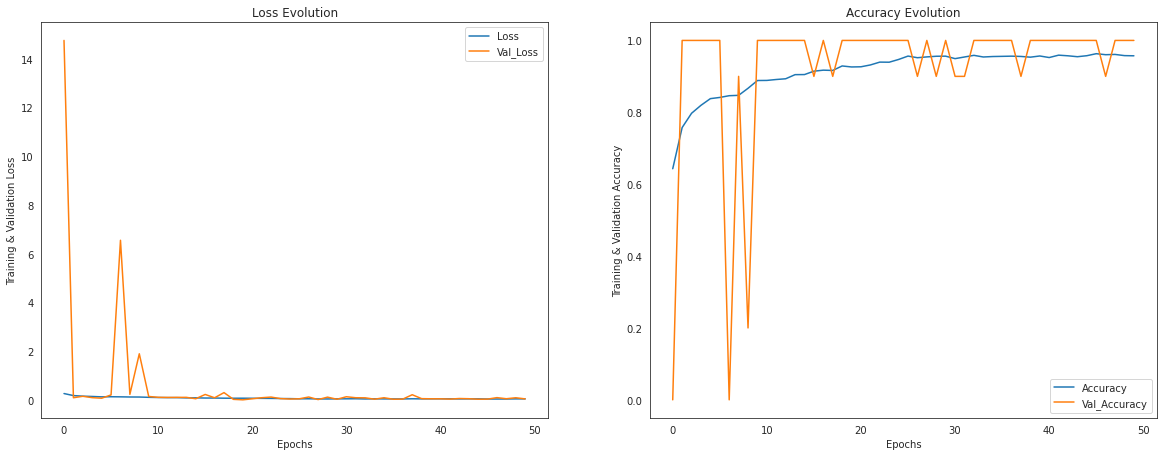

In [16]:
plt.figure(figsize=(20, 16))
#fig , ax = plt.subplots(1,2)

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training & Validation Loss")
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Training & Validation Accuracy")
plt.title('Accuracy Evolution')

In [17]:

evaluation = resnet_model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

evaluation =resnet_model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

491/491 [==============================] - 49s 101ms/step - loss: 0.0926 - accuracy: 0.9768 - precision: 0.9920 - recall: 0.9766
Train Accuracy: 97.68%
624/624 [==============================] - 7s 11ms/step - loss: 0.1982 - accuracy: 0.9359 - precision: 0.9487 - recall: 0.9487
Test Accuracy: 93.59%


In [18]:
from sklearn.metrics import confusion_matrix, classification_report

pred = resnet_model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

624/624 [==============================] - 7s 10ms/step
[[214  20]
 [ 20 370]]


,0,1,accuracy,macro avg,weighted avg
precision,0.91453,0.948718,0.935897,0.931624,0.935897
recall,0.91453,0.948718,0.935897,0.931624,0.935897
f1-score,0.91453,0.948718,0.935897,0.931624,0.935897
support,234.00000,390.000000,0.935897,624.000000,624.000000


<AxesSubplot:>

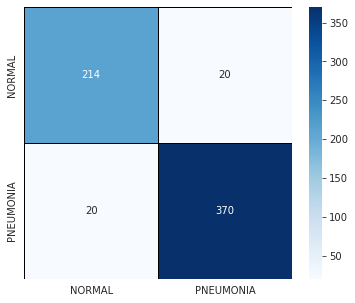

In [19]:
cm=confusion_matrix(test.classes, pred > 0.5)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (6,5))
ll=['NORMAL','PNEUMONIA']
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ll,yticklabels = ll)